In [ ]:
# To show that if there is cuda tookit installed
!ls /usr/local

bin    cuda	cuda-12.5	  etc	 include  libexec     man  sbin   src
colab  cuda-12	dist_metrics.pxd  games  lib	  LICENSE.md  opt  share


In [ ]:
# To show that if there is the nvcc command
!which nvcc

/usr/local/cuda/bin/nvcc


In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-keyring_1.0-1_all.deb
!dpkg -i cuda-keyring_1.0-1_all.deb
!apt update
!apt install -y cuda


--2025-05-19 08:19:40--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-keyring_1.0-1_all.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.40.40.42, 23.40.40.51
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.40.40.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4328 (4.2K) [application/x-deb]
Saving to: ‘cuda-keyring_1.0-1_all.deb’

cuda-keyring_1.0-1_ 100%[===================>]   4.23K  --.-KB/s    in 0s      

2025-05-19 08:19:46 (130 MB/s) - ‘cuda-keyring_1.0-1_all.deb’ saved [4328/4328]

dpkg: warning: downgrading cuda-keyring from 1.1-1 to 1.0-1
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack cuda-keyring_1.0-1_all.deb ...
Unpacking cuda-keyring (1.0-1) over (1.1-1) ...
Setting up cuda-keyring (1.0-1) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer

In [ ]:
!apt-get update
!apt-get install -y libopencv-dev
#!apt-get install -y cuda

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources

In [ ]:
#!apt-get update
!apt-get install -y cmake g++ wget unzip
!apt-get install -y libopencv-dev
!apt-get install -y libopencv-core-dev libopencv-highgui-dev libopencv-imgproc-dev libopencv-videoio-dev
!apt-get install -y libopencv-contrib-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
unzip is already the newest version (6.0-26ubuntu3.2).
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-core-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy1).
libopencv-core-dev set to manually installed.
libopencv-highgui-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy1).
libopencv-highgui-dev set to manually in

In [ ]:
!nvcc --version
!nvidia-smi


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Mon May 19 08:22:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8       

In [ ]:
from google.colab import files

# carica manualmente un file dal computer e lo salva nella directory /content
uploaded = files.upload()

# Salva il nome del file caricato su 'filename.txt'
filename = next(iter(uploaded))
with open('/content/filename.txt', 'w') as f:
    f.write(filename)


Saving gorilla.png to gorilla.png


In [ ]:
%%writefile sequential_code_colab.cu

// CODICE SEQUENZIALE

#include <opencv2/opencv.hpp>
#include <string>
#include <array>
#include <algorithm>
#include <cmath>
#include <chrono>
#include <iostream>
#include <fstream>
#include <numeric>

using namespace cv;
using namespace std;

const int HIST_SIZE = 256; // Number of gray levels in an 8-bit image (0-255)

// Function to determine whether an image is grayscale
bool isGray(const Mat& img) {

    cout << "Channels: " << img.channels() << endl;
    if (img.channels() == 1) return true;

    if (img.channels() == 3 || img.channels() == 4) {
        int stepY = max(1, img.rows / 10);
        int stepX = max(1, img.cols / 10);
        const int tolerance = 1; // accepts slight variations

        for (int y = 0; y < img.rows; y += stepY) {
            for (int x = 0; x < img.cols; x += stepX) {
                if (img.channels() == 3) {
                    Vec3b pixel = img.at<Vec3b>(y, x);
                    if (abs(pixel[0] - pixel[1]) > tolerance || abs(pixel[1] - pixel[2]) > tolerance)
                        return false;
                } else { // BGRA
                    Vec4b pixel = img.at<Vec4b>(y, x);
                    if (abs(pixel[0] - pixel[1]) > tolerance || abs(pixel[1] - pixel[2]) > tolerance)
                        return false;
                }
            }
        }
        return true;
    }

    return false;
}


void computeGrayHistogram(const Mat& img, array<int, HIST_SIZE>& hist) {
    hist.fill(0);  // Initialize all counters to 0
    for (int y = 0; y < img.rows; ++y) {
        for (int x = 0; x < img.cols; ++x) {
            int val = img.at<uchar>(y, x);  // For each pixel, I get the gray level and increase the counter
            hist[val]++;
        }
    }
}

void showGrayHistogram(const array<int, HIST_SIZE>& hist, const string& filename) {
    int hist_w = 512, hist_h = 400;
    int bin_w = cvRound((double) hist_w / HIST_SIZE);

    Mat histImage(hist_h, hist_w, CV_8UC1, Scalar(255));

    int maxVal = *max_element(hist.begin(), hist.end());

    for (int i = 0; i < HIST_SIZE; i++) {
        int intensity = cvRound(((double) hist[i] / maxVal) * hist_h);
        line(histImage,
             Point(bin_w * i, hist_h),
             Point(bin_w * i, hist_h - intensity),
             Scalar(0), 2);
    }

    imwrite(filename, histImage);
}


void computeColorHistogram(const Mat& img, array<int, HIST_SIZE>& histB,
                                          array<int, HIST_SIZE>& histG,
                                          array<int, HIST_SIZE>& histR) {
    histB.fill(0); histG.fill(0); histR.fill(0);  // initializes a histogram for each color
    for (int y = 0; y < img.rows; ++y) {
        for (int x = 0; x < img.cols; ++x) {
            Vec3b pixel = img.at<Vec3b>(y, x); //Each pixel has 3 values: [B, G, R]. I increment the counters in the respective histograms.
            histB[pixel[0]]++;
            histG[pixel[1]]++;
            histR[pixel[2]]++;
        }
    }
}


void showColorHistogram(const array<int, HIST_SIZE>& histB,
                        const array<int, HIST_SIZE>& histG,
                        const array<int, HIST_SIZE>& histR,
                        const string& filename) {
    int hist_w = 512, hist_h = 400;
    int bin_w = cvRound((double) hist_w / HIST_SIZE);

    Mat histImage(hist_h, hist_w, CV_8UC3, Scalar(255,255,255)); // White background

    // Find the global maximum among the three channels
    int maxValB = *max_element(histB.begin(), histB.end());
    int maxValG = *max_element(histG.begin(), histG.end());
    int maxValR = *max_element(histR.begin(), histR.end());
    int maxVal = max(maxValB, max(maxValG, maxValR));

    // Use global maximum to normalize all channels
    for (int i = 0; i < HIST_SIZE; i++) {
        int hB = cvRound(((double) histB[i] / maxVal) * hist_h);
        int hG = cvRound(((double) histG[i] / maxVal) * hist_h);
        int hR = cvRound(((double) histR[i] / maxVal) * hist_h);

        line(histImage, Point(bin_w * i, hist_h), Point(bin_w * i, hist_h - hB), Scalar(255, 0, 0), 1);
        line(histImage, Point(bin_w * i, hist_h), Point(bin_w * i, hist_h - hG), Scalar(0, 255, 0), 1);
        line(histImage, Point(bin_w * i, hist_h), Point(bin_w * i, hist_h - hR), Scalar(0, 0, 255), 1);
    }

    imwrite(filename, histImage);
}


// compute equalized histogram
array<int, HIST_SIZE> equalizeHistogram(const array<int, HIST_SIZE>& hist, int total_pixels) {
    array<double, HIST_SIZE> cdf = {};
    array<int, HIST_SIZE> mapping = {};
    array<int, HIST_SIZE> equalized_hist = {};

    // Compute CDF
    cdf[0] = hist[0];
    for (int i = 1; i < HIST_SIZE; i++) {
        cdf[i] = cdf[i - 1] + hist[i];
    }

    // Find the first value > 0 in the CDF
    double cdf_min = 0;
    for (int i = 0; i < HIST_SIZE; i++) {
        if (cdf[i] > 0) {
            cdf_min = cdf[i];
            break;
        }
    }

    // Create mapping for each intensity level
    for (int i = 0; i < HIST_SIZE; i++) {
        mapping[i] = round((cdf[i] - cdf_min) / (total_pixels - cdf_min) * (HIST_SIZE - 1));
    }

    // Create the equalized histogram by applying the mapping
    for (int i = 0; i < HIST_SIZE; i++) {
        int new_intensity = mapping[i];
        if (new_intensity >= 0 && new_intensity < HIST_SIZE) {
            equalized_hist[new_intensity] += hist[i];
        }
    }

    return equalized_hist;
}

// compute equalized image
Mat equalizeGrayImage(const Mat& grayImg, const array<int, HIST_SIZE>& hist) {

    int total_pixels = grayImg.rows * grayImg.cols;

    // Compute CDF
    array<double, HIST_SIZE> cdf = {};
    array<int, HIST_SIZE> mapping = {};

    cdf[0] = hist[0];
    for (int i = 1; i < HIST_SIZE; ++i) {
        cdf[i] = cdf[i - 1] + hist[i];
    }

    // Find the first value > 0 in the CDF
    double cdf_min = 0;
    for (int i = 0; i < HIST_SIZE; ++i) {
        if (cdf[i] > 0) {
            cdf_min = cdf[i];
            break;
        }
    }

    // Create mapping for each intensity level
    for (int i = 0; i < HIST_SIZE; ++i) {
        mapping[i] = round((cdf[i] - cdf_min) / (total_pixels - cdf_min) * (HIST_SIZE - 1));
    }

    // Creates the equalized image by applying the mapping
    Mat equalized = grayImg.clone();
    for (int y = 0; y < grayImg.rows; ++y) {
        for (int x = 0; x < grayImg.cols; ++x) {
            int val = grayImg.at<uchar>(y, x);
            equalized.at<uchar>(y, x) = mapping[val];
        }
    }

    return equalized;
}

// equalized color image
Mat equalizeColorImage(const Mat& colorImg) {
    CV_Assert(colorImg.channels() == 3);

    // Channel separation
    vector<Mat> channels;
    split(colorImg, channels);

    // Equalize each channel individually
    for (int c = 0; c < 3; ++c) {
        // Calculation of the histogram for the current channel
        array<int, HIST_SIZE> hist = {};
        hist.fill(0);

        for (int y = 0; y < channels[c].rows; ++y) {
            for (int x = 0; x < channels[c].cols; ++x) {
                int val = channels[c].at<uchar>(y, x);
                hist[val]++;
            }
        }

        // Compute CDF
        array<double, HIST_SIZE> cdf = {};
        cdf[0] = hist[0];
        for (int i = 1; i < HIST_SIZE; ++i) {
            cdf[i] = cdf[i - 1] + hist[i];
        }

        double cdf_min = 0;
        for (int i = 0; i < HIST_SIZE; ++i) {
            if (cdf[i] > 0) {
                cdf_min = cdf[i];
                break;
            }
        }

        array<uchar, HIST_SIZE> lut = {};
        int total_pixels = colorImg.rows * colorImg.cols;
        for (int i = 0; i < HIST_SIZE; ++i) {
            lut[i] = round((cdf[i] - cdf_min) / (total_pixels - cdf_min) * (HIST_SIZE - 1));
        }

        // Apply the mapping to the channel
        for (int y = 0; y < channels[c].rows; ++y) {
            for (int x = 0; x < channels[c].cols; ++x) {
                int old_val = channels[c].at<uchar>(y, x);
                channels[c].at<uchar>(y, x) = lut[old_val];
            }
        }
    }

    // Equalized channel union
    Mat equalized;
    merge(channels, equalized);
    return equalized;
}



int main() {

  string filename_path = "/content/filename.txt";
  ifstream file(filename_path);

  string filename;
  if (file.is_open()) {
      getline(file, filename);
      file.close();
  } else {
      cerr << "Errore nell'aprire filename.txt" << endl;
      return 1;
  }

  filename = "/content/" + filename;

  Mat img = imread(filename, IMREAD_UNCHANGED);

  if (img.empty()) {
      cerr << "Impossibile aprire l'immagine: " << filename << endl;
      return -1;
  }

  resize(img, img, Size(img.cols / 4, img.rows / 4));
  imwrite("original_img.jpg", img);

  // EXECUTION TIME
  string csvPath = "/content/sequential_times.csv";
  const int repetitions = 10;
  vector<double> times;

  for (int i = 0; i < repetitions; ++i) {
    auto start = chrono::high_resolution_clock::now();

    if (isGray(img)) {

          Mat imgGray;
          if (img.channels() == 3 || img.channels() == 4) {
              cvtColor(img, imgGray, COLOR_BGR2GRAY);
          } else {
              imgGray = img;
          }

          array<int, HIST_SIZE> histGray;
          computeGrayHistogram(imgGray, histGray);  // Calculates the histogram of the original image
          showGrayHistogram(histGray, "hist_original.jpg");
          cout << "Istogramma in scala di grigi calcolato con successo." << endl;

          // EQUALIZZAZIONE

          Mat eqGrayImg = equalizeGrayImage(imgGray, histGray);
          imwrite("equalized_img.jpg", eqGrayImg);

          // ISTOGRAMMA EQUALIZZATO

          array<int, HIST_SIZE> histEqualized;
          computeGrayHistogram(eqGrayImg, histEqualized);
          showGrayHistogram(histEqualized, "equalized_hist.jpg");
          cout << "Istogramma equalizzato (grayscale) calcolato con successo." << endl;

      } else { // COLOR IMAGE

          Mat imgColor;

          if (img.channels() == 1) {
            cvtColor(img, imgColor, COLOR_GRAY2BGR); // From grayscale to BGR
          } else if (img.channels() == 4) {
            cvtColor(img, imgColor, COLOR_BGRA2BGR); // From RGBA to BGR
          } else {
            imgColor = img; // Already 3-channel
          }

          array<int, HIST_SIZE> histB, histG, histR;
          computeColorHistogram(imgColor, histB, histG, histR); // Calculates the histogram of the original image
          showColorHistogram(histB, histG, histR, "hist_original.jpg");
          cout << "Istogramma a colori calcolato con successo." << endl;

          // EQUALIZZAZIONE

          Mat eqColorImg = equalizeColorImage(imgColor);
          imwrite("equalized_img.jpg", eqColorImg);

          // ISTOGRAMMA EQUALIZZATO

          array<int, HIST_SIZE> equalizedB, equalizedG, equalizedR;
          computeColorHistogram(eqColorImg, equalizedB, equalizedG, equalizedR);
          showColorHistogram(equalizedB, equalizedG, equalizedR, "equalized_hist.jpg");
          cout << "Istogramma equalizzato (RGB) calcolato con successo." << endl;
      }

      auto end = chrono::high_resolution_clock::now();
      chrono::duration<double, milli> duration = end - start;
      cout << "Tempo sequenziale: "
            << duration.count()
            << " ms\n";
      times.push_back(duration.count());
  }


    ofstream csvFile(csvPath);
    csvFile << "Run,Time(ms)\n";
    for (size_t i = 0; i < times.size(); ++i) {
        csvFile << (i + 1) << "," << times[i] << "\n";
    }

    csvFile.close();

    return 0;


}


Writing sequential_code_colab.cu


In [ ]:
!nvcc -arch=sm_75 -Xcudafe "--diag_suppress=611" sequential_code_colab.cu -o sequential_code_colab.cu `pkg-config --cflags --libs opencv4`

In [ ]:
!./sequential_code_colab.cu

Channels: 4
Istogramma in scala di grigi calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo sequenziale: 41.9595 ms
Channels: 4
Istogramma in scala di grigi calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo sequenziale: 41.6981 ms
Channels: 4
Istogramma in scala di grigi calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo sequenziale: 41.0827 ms
Channels: 4
Istogramma in scala di grigi calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo sequenziale: 41.9215 ms
Channels: 4
Istogramma in scala di grigi calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo sequenziale: 41.9454 ms
Channels: 4
Istogramma in scala di grigi calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo sequenziale: 40.8299 ms
Channels: 4
Istogramma in scala di grigi calcolato con successo.
Istogramma 

In [ ]:
%%writefile parallel_code_colab.cu

// CODICE PARALLELO

#include <opencv2/opencv.hpp>
#include <iostream>
#include <fstream>
#include <vector>
#include <array>
#include <algorithm>
#include <numeric>
#include <string>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>

using namespace cv;
using namespace std;

#define HIST_SIZE 256

bool isGray(const Mat& img) {

    cout << "Channels: " << img.channels() << endl;
    if (img.channels() == 1) return true;

    if (img.channels() == 3 || img.channels() == 4) {
        int stepY = max(1, img.rows / 10);
        int stepX = max(1, img.cols / 10);
        const int tolerance = 1;

        for (int y = 0; y < img.rows; y += stepY) {
            for (int x = 0; x < img.cols; x += stepX) {
                if (img.channels() == 3) {
                    Vec3b pixel = img.at<Vec3b>(y, x);
                    if (abs(pixel[0] - pixel[1]) > tolerance || abs(pixel[1] - pixel[2]) > tolerance)
                        return false;
                } else { // BGRA
                    Vec4b pixel = img.at<Vec4b>(y, x);
                    if (abs(pixel[0] - pixel[1]) > tolerance || abs(pixel[1] - pixel[2]) > tolerance)
                        return false;
                }
            }
        }
        return true;
    }

    return false;
}


// Function to allocate memory for image and histograms on the GPU
void allocateMemoryForGPU(const Mat& img, unsigned char*& d_img, int*& d_hist) {

    int totalPixels = img.rows * img.cols;
    cudaMalloc((void**)&d_img, totalPixels * sizeof(unsigned char));

    // Copying the image to the GPU
    cudaMemcpy(d_img, img.data, totalPixels * sizeof(unsigned char), cudaMemcpyHostToDevice);

    cudaMalloc((void**)&d_hist, HIST_SIZE * sizeof(int));
    cudaMemset(d_hist, 0, HIST_SIZE * sizeof(int));
}


// Interleaved Partitioning: This technique improves the efficiency of memory access by ensuring that threads access contiguous memory locations,
// promoting coalescence of accesses.
// Each thread processes multiple pixels of the image, but the pixels are not consecutive.

__global__ void computeHistogramGrayKernel(unsigned char* img, int* hist, int width, int height) {
    __shared__ int localHist[HIST_SIZE];

    int tid = threadIdx.x;
    for (int i = tid; i < HIST_SIZE; i += blockDim.x) {
        localHist[i] = 0;
    }
    __syncthreads();

    int globalIdx = threadIdx.x + blockIdx.x * blockDim.x;
    int stride = blockDim.x * gridDim.x;

    while (globalIdx < width * height) {
        unsigned char gray = img[globalIdx];
        atomicAdd(&localHist[gray], 1);
        globalIdx += stride;
    }

    __syncthreads();

    for (int i = tid; i < HIST_SIZE; i += blockDim.x) {
        atomicAdd(&hist[i], localHist[i]);
    }
}


void computeGrayHistogramCUDA(const Mat& img, array<int, HIST_SIZE>& hist) {
    unsigned char* d_img;
    int* d_hist;

    int totalPixels = img.rows * img.cols;

    cudaMalloc(&d_img, totalPixels * sizeof(unsigned char));
    cudaMemcpy(d_img, img.data, totalPixels * sizeof(unsigned char), cudaMemcpyHostToDevice);

    cudaMalloc(&d_hist, HIST_SIZE * sizeof(int));
    cudaMemset(d_hist, 0, HIST_SIZE * sizeof(int));

    // Kernel configuration
    int threadsPerBlock = 256;
    int blocksPerGrid = (totalPixels + threadsPerBlock - 1) / threadsPerBlock;

    computeHistogramGrayKernel<<<blocksPerGrid, threadsPerBlock>>>(
        d_img, d_hist, img.cols, img.rows
    );

    cudaDeviceSynchronize();

    // Copying the histogram from the GPU to the CPU
    cudaMemcpy(hist.data(), d_hist, HIST_SIZE * sizeof(int), cudaMemcpyDeviceToHost);

    // Memory cleaning
    cudaFree(d_img);
    cudaFree(d_hist);
}


void showGrayHistogram(const array<int, HIST_SIZE>& hist, const string& filename) {
    int hist_w = 512, hist_h = 400;
    int bin_w = cvRound((double) hist_w / HIST_SIZE);

    Mat histImage(hist_h, hist_w, CV_8UC1, Scalar(255));

    int maxVal = *max_element(hist.begin(), hist.end());

    for (int i = 0; i < HIST_SIZE; i++) {
        int intensity = cvRound(((double) hist[i] / maxVal) * hist_h);
        line(histImage,
             Point(bin_w * i, hist_h),
             Point(bin_w * i, hist_h - intensity),
             Scalar(0), 2);
    }

    imwrite(filename, histImage);
}



__global__ void computeHistogramColorKernel(unsigned char* img, int* histB, int* histG, int* histR, int width, int height) {
    // shared memory
    __shared__ int localHistB[HIST_SIZE];
    __shared__ int localHistG[HIST_SIZE];
    __shared__ int localHistR[HIST_SIZE];

    int tid = threadIdx.x;
    for (int i = tid; i < HIST_SIZE; i += blockDim.x) {
        localHistB[i] = 0;
        localHistG[i] = 0;
        localHistR[i] = 0;
    }
    __syncthreads();

    // Global index
    int index = threadIdx.x + blockIdx.x * blockDim.x;
    int stride = blockDim.x * gridDim.x;

    while (index < width * height) {
        int pixelIdx = index * 3;
        unsigned char b = img[pixelIdx];
        unsigned char g = img[pixelIdx + 1];
        unsigned char r = img[pixelIdx + 2];

        // Update shared memory
        atomicAdd(&localHistB[b], 1);
        atomicAdd(&localHistG[g], 1);
        atomicAdd(&localHistR[r], 1);

        index += stride;
    }

    __syncthreads();  // All threads must have finished

    for (int i = tid; i < HIST_SIZE; i += blockDim.x) {
        atomicAdd(&histB[i], localHistB[i]);
        atomicAdd(&histG[i], localHistG[i]);
        atomicAdd(&histR[i], localHistR[i]);
    }
}

void computeColorHistogramCUDA(const Mat& img, array<int, HIST_SIZE>& histB, array<int, HIST_SIZE>& histG, array<int, HIST_SIZE>& histR) {
    unsigned char* d_img;
    int* d_histB;
    int* d_histG;
    int* d_histR;

    int totalPixels = img.rows * img.cols;
    int totalBytes = totalPixels * 3; // B, G, R

    cudaMalloc(&d_img, totalBytes * sizeof(unsigned char));
    cudaMemcpy(d_img, img.data, totalBytes * sizeof(unsigned char), cudaMemcpyHostToDevice);

    cudaMalloc(&d_histB, HIST_SIZE * sizeof(int));
    cudaMalloc(&d_histG, HIST_SIZE * sizeof(int));
    cudaMalloc(&d_histR, HIST_SIZE * sizeof(int));

    cudaMemset(d_histB, 0, HIST_SIZE * sizeof(int));
    cudaMemset(d_histG, 0, HIST_SIZE * sizeof(int));
    cudaMemset(d_histR, 0, HIST_SIZE * sizeof(int));

    int threadsPerBlock = 256;
    int blocksPerGrid = (totalPixels + threadsPerBlock - 1) / threadsPerBlock;

    computeHistogramColorKernel<<<blocksPerGrid, threadsPerBlock>>>(
        d_img, d_histB, d_histG, d_histR, img.cols, img.rows
    );

    cudaDeviceSynchronize();

    cudaMemcpy(histB.data(), d_histB, HIST_SIZE * sizeof(int), cudaMemcpyDeviceToHost);
    cudaMemcpy(histG.data(), d_histG, HIST_SIZE * sizeof(int), cudaMemcpyDeviceToHost);
    cudaMemcpy(histR.data(), d_histR, HIST_SIZE * sizeof(int), cudaMemcpyDeviceToHost);

    cudaFree(d_img);
    cudaFree(d_histB);
    cudaFree(d_histG);
    cudaFree(d_histR);
}



void showColorHistogram(const array<int, HIST_SIZE>& histB,
                        const array<int, HIST_SIZE>& histG,
                        const array<int, HIST_SIZE>& histR,
                        const string& filename) {
    int hist_w = 512, hist_h = 400;
    int bin_w = cvRound((double) hist_w / HIST_SIZE);

    Mat histImage(hist_h, hist_w, CV_8UC3, Scalar(255, 255, 255));

    int maxValB = *max_element(histB.begin(), histB.end());
    int maxValG = *max_element(histG.begin(), histG.end());
    int maxValR = *max_element(histR.begin(), histR.end());
    int maxVal = max(maxValB, max(maxValG, maxValR));

    for (int i = 0; i < HIST_SIZE; i++) {
        int hB = cvRound(((double) histB[i] / maxVal) * hist_h);
        int hG = cvRound(((double) histG[i] / maxVal) * hist_h);
        int hR = cvRound(((double) histR[i] / maxVal) * hist_h);

        line(histImage, Point(bin_w * i, hist_h), Point(bin_w * i, hist_h - hB), Scalar(255, 0, 0), 1);
        line(histImage, Point(bin_w * i, hist_h), Point(bin_w * i, hist_h - hG), Scalar(0, 255, 0), 1);
        line(histImage, Point(bin_w * i, hist_h), Point(bin_w * i, hist_h - hR), Scalar(0, 0, 255), 1);
    }

    imwrite(filename, histImage);
}


__global__ void normalizeHistogram(const int* hist, float* histNorm, int totalPixels) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    if (tid < HIST_SIZE) {
        histNorm[tid] = static_cast<float>(hist[tid]) / totalPixels;
    }
}



// In probability theory and statistics, the cumulative distribution function (CDF) of a real-valued random variable X,
// evaluated at x, is the probability that X will take a value less than or equal to x.

__global__ void computeCDF(float* histNorm, float* cdf) {
    __shared__ float temp[HIST_SIZE];
    int tid = threadIdx.x;

    if (tid < HIST_SIZE) {
        temp[tid] = histNorm[tid];
    }

    __syncthreads();

    for (int stride = 1; stride < HIST_SIZE; stride *= 2) {
        float val = 0;
        if (tid >= stride)
            val = temp[tid - stride];
        __syncthreads();
        temp[tid] += val;
        __syncthreads();
    }

    if (tid < HIST_SIZE) {
        cdf[tid] = temp[tid];
    }
}


__global__ void applyEqualization(unsigned char* d_img, float* d_cdf, unsigned char* d_result, int size) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    if (tid < size) {
        unsigned char val = d_img[tid];
        d_result[tid] = static_cast<unsigned char>(255 * d_cdf[val]);
    }
}


void equalizeHistogramCUDA(const Mat& input, Mat& output) {
    int totalPixels = input.rows * input.cols;

    unsigned char* h_result = new unsigned char[totalPixels];

    unsigned char *d_img, *d_result;
    int *d_hist;
    float *d_histNorm, *d_cdf;

    cudaMalloc(&d_img, totalPixels * sizeof(unsigned char));
    cudaMalloc(&d_result, totalPixels * sizeof(unsigned char));
    cudaMalloc(&d_hist, HIST_SIZE * sizeof(int));
    cudaMalloc(&d_histNorm, HIST_SIZE * sizeof(float));
    cudaMalloc(&d_cdf, HIST_SIZE * sizeof(float));

    cudaMemcpy(d_img, input.data, totalPixels * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemset(d_hist, 0, HIST_SIZE * sizeof(int));

    int threads = 256;
    int blocks = (totalPixels + threads - 1) / threads;
    computeHistogramGrayKernel<<<blocks, threads>>>(d_img, d_hist, input.cols, input.rows);

    normalizeHistogram<<<1, HIST_SIZE>>>(d_hist, d_histNorm, totalPixels);

    computeCDF<<<1, HIST_SIZE>>>(d_histNorm, d_cdf);

    applyEqualization<<<blocks, threads>>>(d_img, d_cdf, d_result, totalPixels);

    cudaMemcpy(h_result, d_result, totalPixels * sizeof(unsigned char), cudaMemcpyDeviceToHost);
    output = Mat(input.rows, input.cols, CV_8UC1, h_result).clone();

    delete[] h_result;
    cudaFree(d_img);
    cudaFree(d_result);
    cudaFree(d_hist);
    cudaFree(d_histNorm);
    cudaFree(d_cdf);
}


void equalizeColorImageCUDA(const Mat& inputColor, Mat& outputColor) {
    vector<Mat> channels;
    split(inputColor, channels); // B, G, R

    vector<Mat> equalizedChannels(3);

    for (int i = 0; i < 3; ++i) {
        equalizeHistogramCUDA(channels[i], equalizedChannels[i]);
    }

    merge(equalizedChannels, outputColor);
}


int main() {

  string filename_path = "/content/filename.txt";
  ifstream file(filename_path);

  string filename;
  if (file.is_open()) {
      getline(file, filename);
      file.close();
  } else {
      cerr << "Errore nell'aprire filename.txt" << endl;
      return 1;
  }

  filename = "/content/" + filename;

  Mat img = imread(filename, IMREAD_UNCHANGED);

  if (img.empty()) {
      cerr << "Impossibile aprire l'immagine: " << filename << endl;
      return -1;
  }

  resize(img, img, Size(img.cols / 4, img.rows / 4));
  imwrite("original_img.jpg", img);

  // EXECUTION TIME
  string csvPath = "/content/parallel_times.csv";
  const int repetitions = 10;
  vector<float> times;

  for (int i = 0; i < repetitions; ++i) {

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);


    if (isGray(img)) {

        Mat imgGray;
        if (img.channels() == 3 || img.channels() == 4) {
            cvtColor(img, imgGray, COLOR_BGR2GRAY);
        } else {
            imgGray = img;
        }

        // ORIGINAL IMAGE HISTOGRAM
        array<int, HIST_SIZE> histGray = {0};
        computeGrayHistogramCUDA(imgGray, histGray);
        showGrayHistogram(histGray, "hist_original.jpg");
        cout << "Istogramma originale (grayscale) calcolato con successo." << endl;

        // IMAGE EQUALIZATION
        Mat eqGrayImg;
        equalizeHistogramCUDA(imgGray, eqGrayImg);
        imwrite("equalized_img.jpg", eqGrayImg);

        // EQUALIZED IMAGE HISTOGRAM
        array<int, HIST_SIZE> eqHistGray = {0};
        computeGrayHistogramCUDA(eqGrayImg, eqHistGray);
        showGrayHistogram(eqHistGray, "equalized_hist.jpg");
        cout << "Istogramma equalizzato (grayscale) calcolato con successo." << endl;


      } else { //  COLOR IMAGE

          Mat imgColor;

          if (img.channels() == 1) {
            cvtColor(img, imgColor, COLOR_GRAY2BGR);
          } else if (img.channels() == 4) {
            cvtColor(img, imgColor, COLOR_BGRA2BGR);
          } else {
            imgColor = img; //
          }

          // ORIGINAL HISTOGRAM
          array<int, HIST_SIZE> histB = {0}, histG = {0}, histR = {0};
          computeColorHistogramCUDA(imgColor, histB, histG, histR);
          showColorHistogram(histB, histG, histR, "hist_original.jpg");
          cout << "Istogramma originale a colori calcolato con successo." << endl;

          // IMAGE EQUALIZATION
          Mat eqColorImg;
          equalizeColorImageCUDA(imgColor, eqColorImg);
          imwrite("equalized_img.jpg", eqColorImg);

          // EQUALIZED IMAGE HISTOGRAM
          array<int, HIST_SIZE> histEqB = {0}, histEqG = {0}, histEqR = {0};
          computeColorHistogramCUDA(eqColorImg, histEqB, histEqG, histEqR);
          showColorHistogram(histEqB, histEqG, histEqR, "equalized_hist.jpg");
          cout << "Istogramma equalizzato a colori calcolato con successo." << endl;

      }

      // End GPU time measurement
      cudaEventRecord(stop);
      cudaEventSynchronize(stop);
      float milliseconds = 0;
      cudaEventElapsedTime(&milliseconds, start, stop);
      cout << "Tempo GPU (ripetizione " << i + 1 << "): " << milliseconds << " ms" << endl;
      times.push_back(milliseconds);

      cudaEventDestroy(start);
      cudaEventDestroy(stop);
  }


    ofstream csvFile(csvPath);
    csvFile << "Run,Time(ms)\n";
    for (size_t i = 0; i < times.size(); ++i) {
        csvFile << (i + 1) << "," << times[i] << "\n";
    }
    csvFile.close();

    return 0;

}


Writing parallel_code_colab.cu


In [ ]:
!nvcc -arch=sm_75 -Xcudafe "--diag_suppress=611" parallel_code_colab.cu -o parallel_code_colab.cu `pkg-config --cflags --libs opencv4`

In [ ]:
!./parallel_code_colab.cu

Channels: 4
Istogramma originale (grayscale) calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo GPU (ripetizione 1): 14.5316 ms
Channels: 4
Istogramma originale (grayscale) calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo GPU (ripetizione 2): 12.2239 ms
Channels: 4
Istogramma originale (grayscale) calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo GPU (ripetizione 3): 11.6159 ms
Channels: 4
Istogramma originale (grayscale) calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo GPU (ripetizione 4): 11.6486 ms
Channels: 4
Istogramma originale (grayscale) calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo GPU (ripetizione 5): 11.6571 ms
Channels: 4
Istogramma originale (grayscale) calcolato con successo.
Istogramma equalizzato (grayscale) calcolato con successo.
Tempo GPU (ripetizione 6): 11.7772 ms
Chan

In [ ]:
# profiling

!nvprof ./parallel_code_colab.cu

==17287== NVPROF is profiling process 17287, command: ./parallel_code_colab.cu
Channels: 3
Istogramma originale a colori calcolato con successo.
Istogramma equalizzato a colori calcolato con successo.
Tempo GPU (ripetizione 1): 21.0701 ms
Channels: 3
Istogramma originale a colori calcolato con successo.
Istogramma equalizzato a colori calcolato con successo.
Tempo GPU (ripetizione 2): 17.4364 ms
Channels: 3
Istogramma originale a colori calcolato con successo.
Istogramma equalizzato a colori calcolato con successo.
Tempo GPU (ripetizione 3): 15.7888 ms
Channels: 3
Istogramma originale a colori calcolato con successo.
Istogramma equalizzato a colori calcolato con successo.
Tempo GPU (ripetizione 4): 15.6181 ms
Channels: 3
Istogramma originale a colori calcolato con successo.
Istogramma equalizzato a colori calcolato con successo.
Tempo GPU (ripetizione 5): 16.006 ms
Channels: 3
Istogramma originale a colori calcolato con successo.
Istogramma equalizzato a colori calcolato con successo.


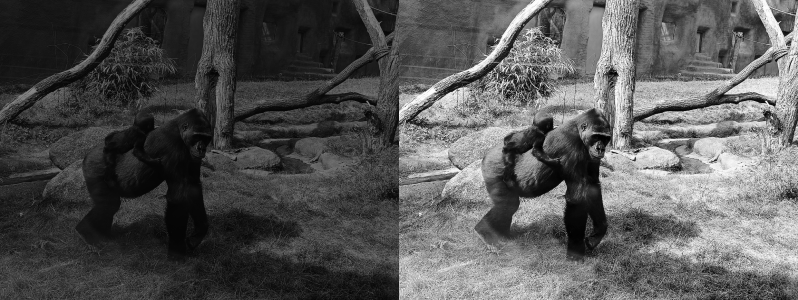

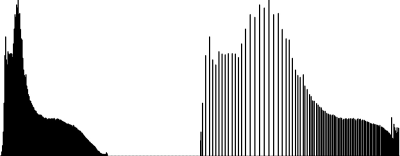

In [ ]:
from IPython.display import display
from PIL import Image as PILImage
import cv2
import numpy as np
import os

def resize_image(image, max_width):
    h, w = image.shape[:2]
    if w > max_width:
        scale = max_width / w
        new_w = int(w * scale)
        new_h = int(h * scale)
        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return resized
    else:
        return image

def load_and_resize(filename, max_width):
    if os.path.exists(filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV legge in BGR, convertiamo in RGB
        return resize_image(img, max_width)
    else:
        return None


original_img = load_and_resize("original_img.jpg", max_width=400)
equalized_img = load_and_resize("equalized_img.jpg", max_width=400)

# immagini affiancate
images = [img for img in [original_img, equalized_img] if img is not None]
if images:
    combined_img = np.hstack(images)
    display(PILImage.fromarray(combined_img))


hist_original = load_and_resize("hist_original.jpg", max_width = 200)
hist_equalized = load_and_resize("equalized_hist.jpg", max_width = 200)

hists = [img for img in [hist_original, hist_equalized] if img is not None]
if hists:
    combined_hist = np.hstack(hists)
    display(PILImage.fromarray(combined_hist))


Tempo medio sequenziale: 41.69 ms
Tempo medio parallelo: 13.05 ms


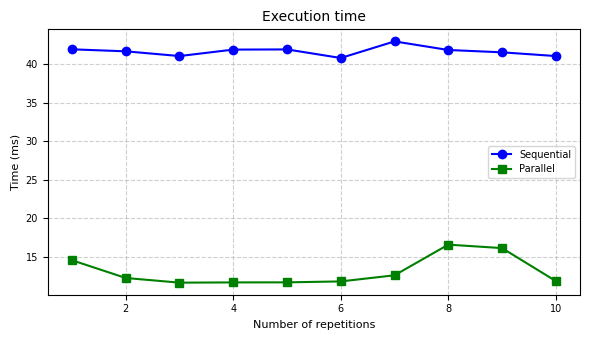

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sequential_csv = "/content/sequential_times.csv"
parallel_csv = "/content/parallel_times.csv"

seq_df = pd.read_csv(sequential_csv).dropna().iloc[:10]
par_df = pd.read_csv(parallel_csv).dropna().iloc[:10]

seq_times = seq_df['Time(ms)'].astype(float).tolist()
par_times = par_df['Time(ms)'].astype(float).tolist()

mean_seq = sum(seq_times) / len(seq_times)
mean_par = sum(par_times) / len(par_times)
print(f"Average sequential time: {mean_seq:.2f} ms")
print(f"Parallel mean time: {mean_par:.2f} ms")


# Plot
plt.figure(figsize=(6, 3.5))
plt.plot(range(1, 11), seq_times, label='Sequential', marker='o', color='blue')
plt.plot(range(1, 11), par_times, label='Parallel', marker='s', color='green')


plt.xlabel('Number of repetitions', fontsize=8)
plt.ylabel('Time (ms)', fontsize=8)
plt.title('Execution time', fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('/content/times.png')
plt.show()
